## Yoga posture Detection

In [1]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-04-23 01:35:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-23 01:35:08 (61.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data = r"/content/drive/My Drive/Pose Correction Dataset"

In [13]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [14]:
image_df

,Filepath,Label
0,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
1,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
2,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
3,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
4,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
...,...,...
84,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
85,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
86,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect
87,/content/drive/My Drive/Pose Correction Datase...,Squat Incorrect


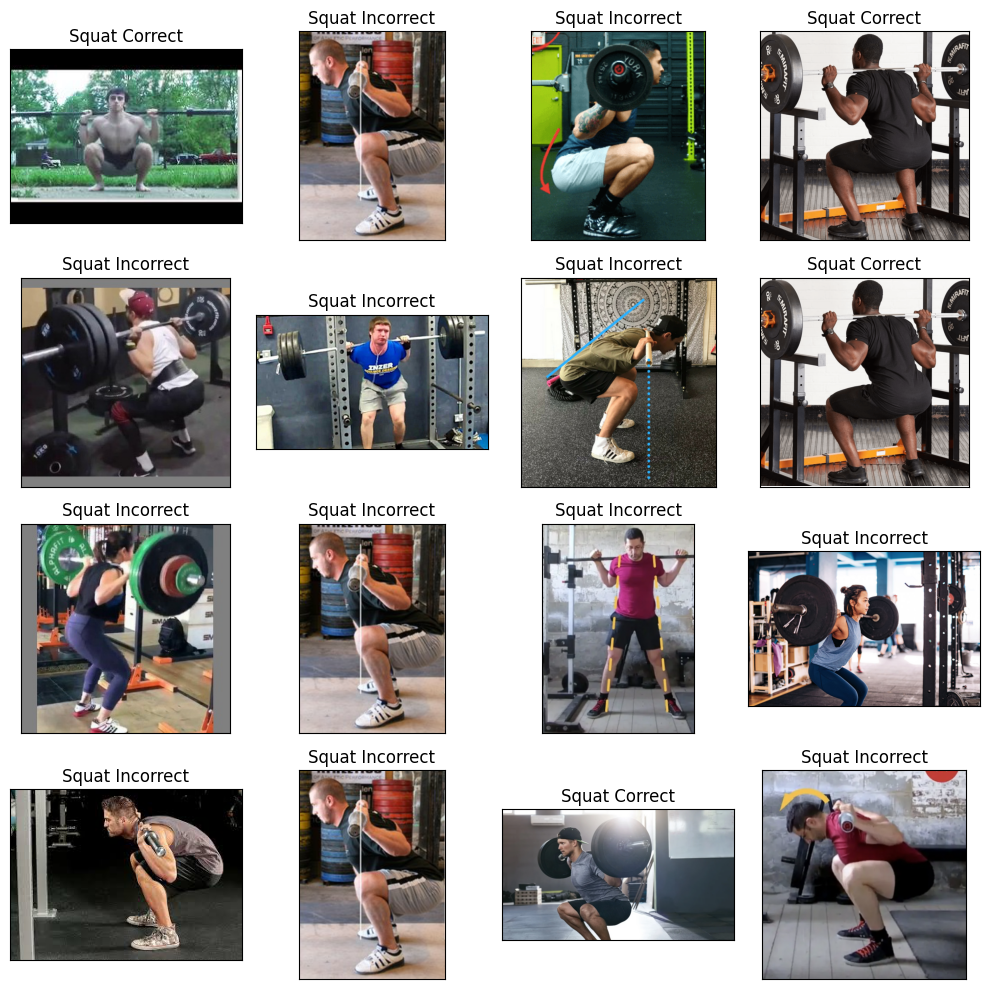

In [15]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10,10), subplot_kw = {'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [16]:
train_df, test_df = train_test_split(image_df, test_size = 0.2, shuffle = True, random_state = 42)

In [38]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input, validation_split = 0.1)
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

In [39]:
# Split data into train, validation and test set

train_images = train_gen.flow_from_dataframe(dataframe = train_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = True,
                                            seed = 42,
                                            subset = 'training')

val_images = train_gen.flow_from_dataframe(dataframe = train_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = True,
                                            seed = 42,
                                            subset = 'validation')

test_images = test_gen.flow_from_dataframe(dataframe = test_df,
                                            x_col = 'Filepath',
                                            y_col = 'Label',
                                            target_size = (224,224),
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            batch_size = 32,
                                            shuffle = False)

Found 64 validated image filenames belonging to 2 classes.
Found 7 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.


In [40]:
#Data Augmentation

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name = 'data_augmentation')

In [41]:
# Load pretrained Model

pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3),include_top = False, weights = 'imagenet', pooling = 'avg')
pretrained_model.trainable = False

In [42]:
# Create checkpoint callback
checkpoint_path = "gym_posture_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [43]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) 
# if val loss decreases for 3 epochs in a row, stop trainin

In [56]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [57]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "gym_posture_classification_model_checkpoint"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/gym_posture_classification_model_checkpoint/20230423-044720
Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 1.0237 - accuracy: 0.4531 - val_loss: 1.0822 - val_accuracy: 0.5714
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 0.7799 - accuracy: 0.6094 - val_loss: 0.6451 - val_accuracy: 0.5714
Epoch 3/10
2/2 [==============================] - 5s 2s/step - loss: 0.5972 - accuracy: 0.6094 - val_loss: 0.5174 - val_accuracy: 0.8571
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.5624 - accuracy: 0.7031 - val_loss: 0.4370 - val_accuracy: 0.8571
Epoch 5/10
2/2 [==============================] - 4s 3s/step - loss: 0.4635 - accuracy: 0.8281 - val_loss: 0.4853 - val_accuracy: 0.7143
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 0.4411 - accuracy: 0.8125 - val_loss: 0.4959 - val_accuracy: 0.7143
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.

In [58]:
results = model.evaluate(val_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39252
Test Accuracy: 85.71%


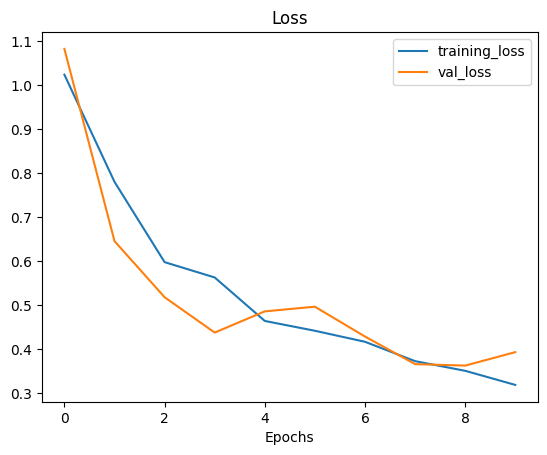

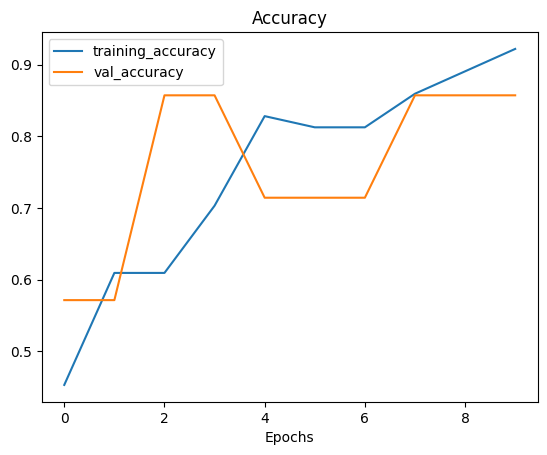

In [59]:
plot_loss_curves(history)

In [53]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 2s 2s/step
The first 5 predictions: ['Squat Correct', 'Squat Correct', 'Squat Correct', 'Squat Incorrect', 'Squat Correct']


In [60]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

  Squat Correct       0.86      0.86      0.86         7
Squat Incorrect       0.91      0.91      0.91        11

       accuracy                           0.89        18
      macro avg       0.88      0.88      0.88        18
   weighted avg       0.89      0.89      0.89        18



In [61]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Squat Correct,0.857143,0.857143,0.857143,7.000000
Squat Incorrect,0.909091,0.909091,0.909091,11.000000
accuracy,0.888889,0.888889,0.888889,0.888889
macro avg,0.883117,0.883117,0.883117,18.000000
weighted avg,0.888889,0.888889,0.888889,18.000000
